In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.optimize import linear_sum_assignment
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
TRAIN_TSV_PATH = "Molecules/train.tsv"
VAL_TSV_PATH = "Molecules/validation.tsv"
GXL_DIR = "Molecules/gxl"

In [3]:
def load_labels(tsv_path):
    labels = {}

    with open(tsv_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines

            parts = line.split()
            if len(parts) != 2:
                continue

            gid_str, label = parts
            gid = int(gid_str)
            labels[gid] = label

    return labels

In [4]:
train_labels = load_labels(TRAIN_TSV_PATH)
val_labels = load_labels(VAL_TSV_PATH)

print("Train size:", len(train_labels))
print("Validation size:", len(val_labels))
print("Train Distribution:", Counter(train_labels.values()))
print("Val Distribution:", Counter(val_labels.values()))

Train size: 250
Validation size: 250
Train Distribution: Counter({'inactive': 200, 'active': 50})
Val Distribution: Counter({'inactive': 200, 'active': 50})


In [5]:
class Graph:
    def __init__(self, node_labels, edges):
        self.node_labels = node_labels
        self.edges = edges

    @property
    def nodes(self):
        return list(self.node_labels.keys())

    def number_of_nodes(self):
        return len(self.node_labels)

    def number_of_edges(self):
        return len(self.edges)

    def __repr__(self):
        return f"Graph(nodes={self.number_of_nodes()}, edges={self.number_of_edges()})"

In [6]:
def load_gxl(path):
    tree = ET.parse(path)
    root = tree.getroot()

    graph_elem = root.find(".//graph")

    node_labels = {}
    edges = set()

    # Parse nodes
    for node in graph_elem.findall("node"):
        node_id = node.attrib["id"]
        symbol_elem = node.find("attr[@name='symbol']/string")

        symbol = symbol_elem.text.strip()
        node_labels[node_id] = symbol

    # Parse edges
    for edge in graph_elem.findall("edge"):
        u = edge.attrib["from"]
        v = edge.attrib["to"]
        edges.add(tuple(sorted((u, v))))

    return Graph(node_labels, edges)

In [7]:
def load_all_graphs(gxl_dir, ids):
    graphs = {}
    for gid in ids:
        path = f"{gxl_dir}/{gid}.gxl"
        graphs[gid] = load_gxl(path)
    return graphs

In [8]:
train_graphs = load_all_graphs(GXL_DIR, train_labels.keys())
val_graphs = load_all_graphs(GXL_DIR, val_labels.keys())

print("Train graphs loaded:", len(train_graphs))
print("Validation graphs loaded:", len(val_graphs))

Train graphs loaded: 250
Validation graphs loaded: 250


In [9]:
# Examples of the first 3 graphs
for gid in list(train_graphs.keys())[:3]:
    print(gid, "-", train_graphs[gid])

11808 - Graph(nodes=10, edges=10)
15905 - Graph(nodes=15, edges=16)
17157 - Graph(nodes=17, edges=18)


In [10]:
def dirac_cost_matrix(G1, G2, Cn):
    V1 = list(G1.node_labels.keys())
    V2 = list(G2.node_labels.keys())

    n = len(V1)
    m = len(V2)

    size = n + m
    C = np.zeros((size, size))

    # Substitution - top-left part
    for i, u in enumerate(V1):
        for j, v in enumerate(V2):
            if G1.node_labels[u] == G2.node_labels[v]:
                C[i, j] = 0.0
            else:
                C[i, j] = 2 * Cn

    # Deletion - top-right part
    for i in range(n):
        for j in range(m, m + n):
            C[i, j] = Cn

    # Insertion - bottom-left part
    for i in range(n, n + m):
        for j in range(m):
            C[i, j] = Cn

    # The bottom-right part remains 0

    return C, V1, V2

In [11]:
def match_nodes_and_vertex_cost(G1, G2, Cn):
    C, V1, V2 = dirac_cost_matrix(G1, G2, Cn)

    n = len(V1)
    m = len(V2)

    row_idxs, col_idxs = linear_sum_assignment(C)
    vertex_cost = C[row_idxs, col_idxs].sum()

    mapping = {}

    for r, c in zip(row_idxs, col_idxs):
        if r < n:
            if c < m:
                mapping[V1[r]] = V2[c]  # substitution
            else:
                mapping[V1[r]] = None  # deletion

    return vertex_cost, mapping

In [12]:
Cn = 1.0

gid = next(iter(train_graphs.keys()))
G = train_graphs[gid]

vertex_cost_gg, mapping_gg = match_nodes_and_vertex_cost(G, G, Cn)

print("Test graph ID:", gid)
print("G vs G vertex cost:", vertex_cost_gg)
print("Number of nodes in G:", G.number_of_nodes())
print("Mapping size:", len(mapping_gg))

# First few samples of mapping
print("\nSample of mapping:")
for i, (u, v) in enumerate(mapping_gg.items()):
    if i >= 10:
        break
    print(u, " - ", v)

Test graph ID: 11808
G vs G vertex cost: 0.0
Number of nodes in G: 10
Mapping size: 10

Sample of mapping:
_1  -  _1
_2  -  _2
_3  -  _3
_4  -  _4
_5  -  _5
_6  -  _6
_7  -  _7
_8  -  _8
_9  -  _9
_10  -  _10


In [13]:
def approximate_ged(G1, G2, Cn, Ce):
    # Node matching and vertex cost
    vertex_cost, mapping = match_nodes_and_vertex_cost(G1, G2, Cn)

    # Edge cost
    # Map edges of G1 to G2 via mapping
    E1_mapped = set()
    for (u, v) in G1.edges:
        u2 = mapping.get(u)
        v2 = mapping.get(v)
        if u2 is not None and v2 is not None:
            E1_mapped.add(tuple(sorted((u2, v2))))

    # Original edges of G2
    E2 = set(G2.edges)

    # Symmetric difference
    diff_edges = (E1_mapped - E2) | (E2 - E1_mapped)
    edge_cost = Ce * len(diff_edges)

    total_cost = vertex_cost + edge_cost
    return total_cost

In [14]:
# Symmetric GED used as the final distance metric for KNN
def symmetric_ged(G1, G2, Cn, Ce):
    d12 = approximate_ged(G1, G2, Cn, Ce)
    d21 = approximate_ged(G2, G1, Cn, Ce)
    return 0.5 * (d12 + d21)

In [15]:
# Predict the label of a single graph
def knn_predict_one(G_test, train_graphs, train_labels, k, Cn, Ce):
    distances = []

    # Compute distances to all training graphs
    for gid, G_train in train_graphs.items():
        d = symmetric_ged(G_test, G_train, Cn, Ce)
        distances.append((d, gid))

    # Select k nearest neighbors
    distances.sort(key=lambda x: x[0])
    k_nearest = distances[:k]

    # Majority vote
    k_labels = [train_labels[gid] for _, gid in k_nearest]
    return Counter(k_labels).most_common(1)[0][0]

In [16]:
# Predict labels for all graphs in the validation set
def knn_predict_all(val_graphs, train_graphs, train_labels, k, Cn, Ce):
    preds = {}
    for vid, G_val in val_graphs.items():
        preds[vid] = knn_predict_one(G_val, train_graphs, train_labels, k, Cn, Ce)
    return preds

In [17]:
k = 5
Cn = 1.0
Ce = 1.0

val_preds = knn_predict_all(val_graphs, train_graphs, train_labels, k=k, Cn=Cn, Ce=Ce)

y_true = [val_labels[gid] for gid in val_labels]
y_pred = [val_preds[gid] for gid in val_labels]

val_acc = accuracy_score(y_true, y_pred)

print("Baseline result.")
print("Validation accuracy:", val_acc)

Baseline result.
Validation accuracy: 0.904


In [18]:
# Grid search - runs for about 8 minutes
ks = [1, 3, 5, 7]
Cns = [0.5, 1.0, 2.0]
Ces = [0.1, 0.5, 1.0]

results = []

counter = 1
for k in ks:
    for cn in Cns:
        for ce in Ces:
            print(f"{counter}. k={k}, Cn={cn}, Ce={ce}")

            preds = knn_predict_all(val_graphs, train_graphs, train_labels, k=k, Cn=cn, Ce=ce)

            y_pred = [preds[gid] for gid in val_labels]
            acc = accuracy_score(y_true, y_pred)

            results.append((k, cn, ce, acc))

            counter += 1

            print("  -> Accuracy:", acc)

1. k=1, Cn=0.5, Ce=0.1
  -> Accuracy: 0.988
2. k=1, Cn=0.5, Ce=0.5
  -> Accuracy: 0.96
3. k=1, Cn=0.5, Ce=1.0
  -> Accuracy: 0.892
4. k=1, Cn=1.0, Ce=0.1
  -> Accuracy: 0.992
5. k=1, Cn=1.0, Ce=0.5
  -> Accuracy: 0.984
6. k=1, Cn=1.0, Ce=1.0
  -> Accuracy: 0.96
7. k=1, Cn=2.0, Ce=0.1
  -> Accuracy: 0.992
8. k=1, Cn=2.0, Ce=0.5
  -> Accuracy: 0.988
9. k=1, Cn=2.0, Ce=1.0
  -> Accuracy: 0.984
10. k=3, Cn=0.5, Ce=0.1
  -> Accuracy: 0.988
11. k=3, Cn=0.5, Ce=0.5
  -> Accuracy: 0.94
12. k=3, Cn=0.5, Ce=1.0
  -> Accuracy: 0.856
13. k=3, Cn=1.0, Ce=0.1
  -> Accuracy: 0.992
14. k=3, Cn=1.0, Ce=0.5
  -> Accuracy: 0.98
15. k=3, Cn=1.0, Ce=1.0
  -> Accuracy: 0.94
16. k=3, Cn=2.0, Ce=0.1
  -> Accuracy: 0.992
17. k=3, Cn=2.0, Ce=0.5
  -> Accuracy: 0.988
18. k=3, Cn=2.0, Ce=1.0
  -> Accuracy: 0.98
19. k=5, Cn=0.5, Ce=0.1
  -> Accuracy: 0.988
20. k=5, Cn=0.5, Ce=0.5
  -> Accuracy: 0.904
21. k=5, Cn=0.5, Ce=1.0
  -> Accuracy: 0.824
22. k=5, Cn=1.0, Ce=0.1
  -> Accuracy: 0.992
23. k=5, Cn=1.0, Ce=0.5
 

In [19]:
# All configurations achieving the best accuracy

best_acc = max(x[3] for x in results)
best_results = [x for x in results if x[3] == best_acc]

for k, cn, ce, acc in best_results:
    print(f"k={k}, Cn={cn}, Ce={ce}, Accuracy={acc:.4f}")

k=1, Cn=1.0, Ce=0.1, Accuracy=0.9920
k=1, Cn=2.0, Ce=0.1, Accuracy=0.9920
k=3, Cn=1.0, Ce=0.1, Accuracy=0.9920
k=3, Cn=2.0, Ce=0.1, Accuracy=0.9920
k=5, Cn=1.0, Ce=0.1, Accuracy=0.9920
k=5, Cn=2.0, Ce=0.1, Accuracy=0.9920


In [20]:
best = max(results, key=lambda x: x[3])

k_best, Cn_best, Ce_best, best_acc = best

k_best = 3 # k=1,3,5 have the same accuracy, but k=3 may be more robust than k=1

print("Best chosen parameters:")
print("k =", k_best)
print("Cn =", Cn_best)
print("Ce =", Ce_best)
print("Accuracy =", best_acc)

Best chosen parameters:
k = 3
Cn = 1.0
Ce = 0.1
Accuracy = 0.992


In [21]:
final_preds = knn_predict_all(val_graphs, train_graphs, train_labels, k=k_best, Cn=Cn_best, Ce=Ce_best)

final_y_pred = [final_preds[gid] for gid in val_labels]
final_acc = accuracy_score(y_true, final_y_pred)

print("\nFinal Accuracy:", final_acc)


Final Accuracy: 0.992


## Visualizations

In [22]:
y_true = [val_labels[gid] for gid in val_labels]
y_pred = [final_preds[gid] for gid in val_labels]

In [23]:
# Precision, recall, F1-score
precision = precision_score(y_true, y_pred, pos_label="active")
recall = recall_score(y_true, y_pred, pos_label="active")
f1 = f1_score(y_true, y_pred, pos_label="active")

print("Precision (active):", precision)
print("Recall (active):", recall)
print("F1-score (active):", f1)

Precision (active): 1.0
Recall (active): 0.96
F1-score (active): 0.9795918367346939


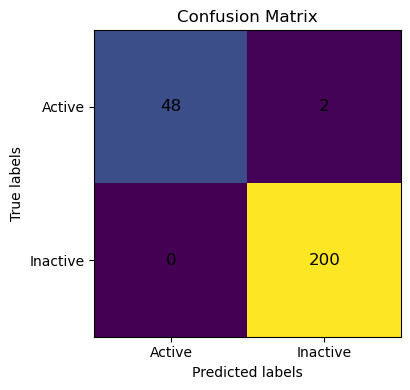

In [24]:
# Confusion matrix
cm_array = confusion_matrix(y_true, y_pred, labels=["active", "inactive"])

plt.figure(figsize=(5, 4))
plt.imshow(cm_array)
plt.title("Confusion Matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ["Active", "Inactive"])
plt.yticks([0, 1], ["Active", "Inactive"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_array[i, j], ha="center", va="center", fontsize=12)

plt.tight_layout()
plt.show()